In [113]:
import numpy as np
import pandas as pd
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import xarray as xr
# Importing the Keras libraries and packages
from keras.models import load_model
from keras.models import save_model
from keras.models import model_from_json
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [78]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
from seaborn import heatmap
import seaborn as sns

In [48]:
from scipy import stats

In [112]:
# for HDF5 data set
import h5py

In [57]:
# cartopy libraries
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree
from cartopy.feature import NaturalEarthFeature, COLORS
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [40]:
"""Plotting parameters"""
#rcParams['axes.formatter.limits'] = (-7, 7)
rcParams['axes.formatter.limits'] = (-2,3)
rcParams['axes.labelsize'] = 24
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = 24
rcParams['font.size'] = 24
rcParams['figure.titlesize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['legend.fontsize'] = 24
%matplotlib inline

In [23]:
# prepare training data
# Importing the dataset
# Data from all sources used in the BioGeosciences paper
fp = '/storage/data3/disk00/disk01/DOC_POC_Stocks/doc_antonio_data.mat'
mat = loadmat(fp) # load mat-file
#cols = ['lat', 'lon', 'yy', 'mm' ,'dd', 'T', 'S',  'z', 'DOC'
cols = ['yy', 'mm' ,'dd', 'lat', 'lon',  'T', 'S',  'z', 'DOC']

mat_small = {}
for col in cols:
    mat_small[col] = mat[col].reshape(-1,)
idx = np.arange(mat_small[col].shape[0])

df = pd.DataFrame(mat_small, index=idx)
df = df[cols]
df.head()

,yy,mm,dd,lat,lon,T,S,z,DOC
0,2009,8,17,41.314,-70.9444,21.06,31.40,2.3,100.98
1,2009,8,17,41.314,-70.9444,20.92,31.40,5.3,144.43
2,2009,8,17,41.314,-70.9444,18.94,31.42,14.4,122.68
3,2009,8,17,41.314,-70.9444,14.00,32.10,29.5,107.59
4,2009,8,18,40.304,-71.8109,22.72,0.50,2.1,80.20


In [24]:
# replace nulls with NaNs plus correct other error in signs, if(z=0) then z=0.5. z=log10(z)
df.replace(-999, value=np.NaN, inplace=True)
df['DOC'] = df['DOC'].abs()
df['lon'] = df['lon'].abs()
df['lon'] = -df['lon']
df.loc[df.z == 0, 'z'] = 0.5
df['z'] = np.log10(df.z)

In [25]:
# remove NaNs
df2 = df.dropna()
df2.head()

,yy,mm,dd,lat,lon,T,S,z,DOC
0,2009.0,8.0,17.0,41.314,-70.9444,21.06,31.40,0.361728,100.98
1,2009.0,8.0,17.0,41.314,-70.9444,20.92,31.40,0.724276,144.43
2,2009.0,8.0,17.0,41.314,-70.9444,18.94,31.42,1.158362,122.68
3,2009.0,8.0,17.0,41.314,-70.9444,14.00,32.10,1.469822,107.59
4,2009.0,8.0,18.0,40.304,-71.8109,22.72,0.50,0.322219,80.20


In [26]:
# remove suspicious values with low DOC (~80 umol/L) and very low salinity
result=df2.S
np.where(result<1)

(array([  4, 513]),)

In [27]:
# remove very low suspicious salinity values with corresponding low marine DOC
df2 = df2[df2.S > 1]
df2.describe()

,yy,mm,dd,lat,lon,T,S,z,DOC
count,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000
mean,2007.300593,6.922100,15.646909,39.185943,-72.992293,13.968298,31.273771,0.835441,94.202523
std,1.909896,2.517537,10.031804,2.260709,2.968911,5.587495,2.909112,0.580120,23.848688
min,2005.000000,2.000000,1.000000,35.745200,-76.069000,2.370000,6.903000,-0.301030,40.630000
25%,2006.000000,5.000000,6.000000,36.966000,-75.298000,10.257700,30.695000,0.414973,78.150000
50%,2007.000000,7.000000,12.000000,38.562500,-74.506000,13.127000,31.917000,0.845098,89.600000
75%,2009.000000,8.000000,27.000000,41.183200,-70.562900,16.390000,32.610000,1.271842,105.420000
max,2010.000000,11.000000,31.000000,44.233200,-65.736400,28.613000,36.180000,2.741254,242.100000


In [28]:
# Create matrix of features and matrix of target variable. Column 8, ‘Exited’ is our Target Variable 
# (Note: Python Indexing start with 0)
# select input variables (lat, lon, T, S, log10[z]) and targeted data (DOC)
#Xin = df2[['lon','lat','T','S','z']]
Xin = df2[['T','S','z']]
Ytgt = df2[['DOC']]

In [29]:
Xin.rename(columns={'T': 'Temp'}, inplace=True)

/accounts/sergio/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [31]:
XY = df2[['lon','lat','T','S','z', 'DOC']]
XY_s = (XY - XY.mean(axis=0)) / XY.std(axis=0)
XY_s.describe()

,lon,lat,T,S,z,DOC
count,1.181000e+03,1.181000e+03,1.181000e+03,1.181000e+03,1.181000e+03,1.181000e+03
mean,-1.172813e-14,-2.441475e-14,-7.710927e-16,-1.923760e-15,5.457320e-15,1.939624e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.036308e+00,-1.521975e+00,-2.075760e+00,-8.377391e+00,-1.959026e+00,-2.246351e+00
25%,-7.766170e-01,-9.819675e-01,-6.640898e-01,-1.989511e-01,-7.247936e-01,-6.730988e-01
50%,-5.098526e-01,-2.757731e-01,-1.505681e-01,2.211083e-01,1.664709e-02,-1.929885e-01
75%,8.182775e-01,8.834649e-01,4.334146e-01,4.593253e-01,7.522595e-01,4.703603e-01
max,2.443958e+00,2.232599e+00,2.620978e+00,1.686504e+00,3.285204e+00,6.201493e+00


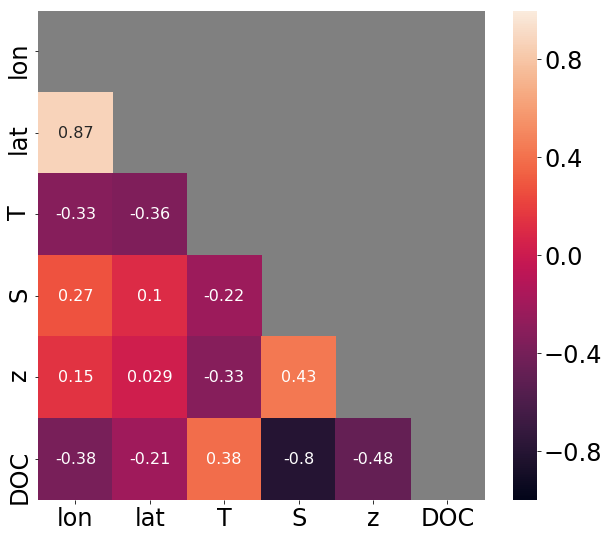

In [46]:
fig, ax = plt.subplots(figsize=(10, 9))
ax.set_facecolor('gray')
heatmap(XY_s.corr(), vmin=-1, vmax=1, annot=True, ax=ax, annot_kws={'fontsize': 16},
       mask=np.triu(np.ones([XY_s.shape[1]]*2)));

In [49]:
# Generated linear fit (DOC vs S)
xs = Xin.S
y = Ytgt.DOC
slope, intercept, r_value, p_value, std_err = stats.linregress(xs,y)
lines = slope*xs+intercept
slope, intercept, r_value, p_value, std_err

# Generated linear fit (DOC vs T)
xt = Xin.Temp
y = Ytgt.DOC
slope, intercept, r_value, p_value, std_err = stats.linregress(xt,y)
linet = slope*xt+intercept
slope, intercept, r_value, p_value, std_err

# Generated linear fit (DOC vs log(zobs)
xz = Xin.z
y = Ytgt.DOC
slope, intercept, r_value, p_value, std_err = stats.linregress(xz,y)
linez = slope*xz+intercept
slope, intercept, r_value, p_value, std_err

(-19.601941874483959,
 110.57878384567623,
 -0.47681790636808946,
 4.473033164592668e-68,
 1.0523968718246353)

Text(0,0.5,'DOC ($\\mu mol/L$)')

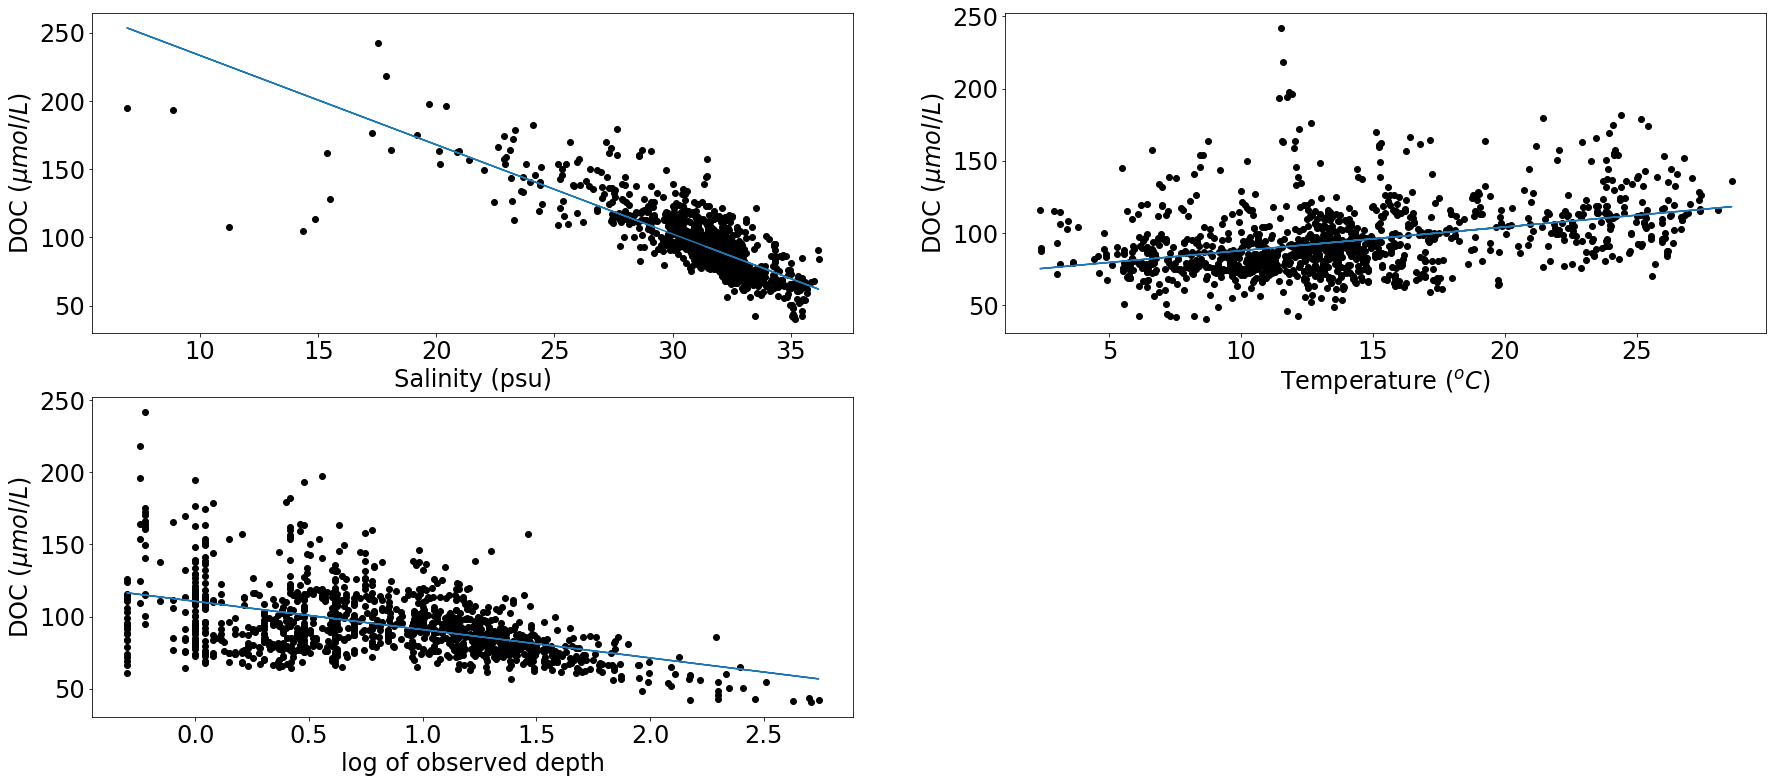

In [50]:
# scatter plots
fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
# ax4 = fig.add_subplot(3,2,4)
# ax5 = fig.add_subplot(3,2,5)

ax1.plot(Xin.S, Ytgt.DOC,'ko', xs, lines)
ax1.set_xlabel('Salinity (psu)')
ax1.set_ylabel('DOC ($\mu mol/L$)')

ax2.plot(Xin.Temp, Ytgt.DOC,'ko', xt, linet)
ax2.set_xlabel('Temperature ($^oC$)')
ax2.set_ylabel('DOC ($\mu mol/L$)')

ax3.plot(Xin.z, Ytgt.DOC,'ko', xz, linez)
ax3.set_xlabel('log of observed depth')
ax3.set_ylabel('DOC ($\mu mol/L$)')


In [53]:
# read DOPPIO grid file
ds_doppio = xr.open_dataset('grid_doppio_JJA_v9.nc')
Ydoppio = ds_doppio.lat_rho
Xdoppio = ds_doppio.lon_rho
hdoppio = ds_doppio.h
Xdoppio.shape

(106, 242)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.LambertCylindrical())
ax.set_extent([-82.5,-58,31,48])
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

land = cfeature.NaturalEarthFeature(
        category='physical', name='land',
        scale='10m', facecolor='grey')

#ocean = NaturalEarthFeature(category='physical', name='ocean',
#                            scale='10m', facecolor=COLORS['water'])

#coastline = NaturalEarthFeature(category='physical', name='coastline',
#                            scale='10m', facecolor='none')

# add bathymetry 
cmap = plt.get_cmap('Blues')
norm = colors.Normalize(0, 5000)

for letter, level in [
                      ('L', 0),
                      ('K', 200),
                      ('J', 1000),
                      ('I', 2000),
                      ('H', 3000),
                      ('G', 4000),
                      ('F', 5000)]:
 
    bathym = NaturalEarthFeature(name='bathymetry_{}_{}'.format(letter, level),
                                 scale='10m', category='physical')
    ax.add_feature(bathym, facecolor=cmap(norm(level)), edgecolor='face')

# plot DOPPIO bathymetry 
plt.contour(Xdoppio, Ydoppio, hdoppio, transform=ccrs.PlateCarree())

# plot DOC station locations
plt.plot(df2.lon, df2.lat, linestyle=' ', color='black', marker='o')

#ax.add_feature(ocean)
#ax.add_feature(bathym_200, facecolor='blue')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 15, 'color': 'black', 'weight': 'bold'}
gl.ylabel_style = {'size': 15, 'color': 'black', 'weight': 'bold'}
gl.xlabels_top = False
gl.ylabels_right = False

# plot DOPPIO boundaries
plt.plot(Xdoppio[0:47,0], Ydoppio[0:47,0], linestyle='-', linewidth=4, color='r')
plt.plot(Xdoppio[0,0:241], Ydoppio[0,0:241], linestyle='-', linewidth=4, color='r')
plt.plot(Xdoppio[0:70,241], Ydoppio[0:70,241], linestyle='-', linewidth=4, color='r')

SOURCE = 'DOC'
TYPE = 'station locations'

ax.add_feature(land)
#ax.add_feature(coastline)
text = AnchoredText(r' {} : {}'
                        ''.format(SOURCE,TYPE),
                        loc=4, prop={'size': 14}, frameon=True)
ax.add_artist(text)

fig.tight_layout(h_pad=0.013)
fig.savefig('Figures/DOCdata_DOPPIOgrid_bndry.png',dpi=300)

### Define the Model

In [66]:
##define base model
def base_model():
     model = Sequential()
     model.add(Dense(14, input_dim=3, init='normal', activation='relu'))
     model.add(Dense(7, init='normal', activation='relu'))
     model.add(Dense(1, init='normal'))
     model.compile(loss='mean_squared_error', optimizer = 'adam')
     return model

seed = 7
np.random.seed(seed)

In [ ]:
# the deeper network topology looks like (one more hidden layer with 7 neurons) :
# 3 inputs -> [14 -> 7] -> 1 output

In [68]:
# keras sequential regressor model
doc_keras_model = KerasRegressor(build_fn=base_model, epochs=100, batch_size=5,verbose=0)

### Fitting 

In [69]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xin, Ytgt, test_size = 0.2)

In [70]:
# Feature Scaling - scale input train and test variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [71]:
# fit the model with training data
doc_keras_model.fit(X_train,y_train)

/accounts/sergio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(14, input_dim=3, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/accounts/sergio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(7, activation="relu", kernel_initializer="normal")`
  """
/accounts/sergio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
  


### Testing and Predicitng

In [83]:
# predict using model with test data input
y_pred = doc_keras_model.predict(X_test)
# predict using model with training data input
y_pred2 = doc_keras_model.predict(X_train)

In [122]:
# get mean absolute error for training and testing fits
from sklearn.metrics import mean_absolute_error
score1 = mean_absolute_error(y_test, doc_keras_model.predict(X_test))

from sklearn.metrics import mean_absolute_error
score2 = mean_absolute_error(y_train, doc_keras_model.predict(X_train))
score1, score2

(9.8695278904910833, 8.6110025331529503)

In [85]:
# Generated linear fit line for training data
slope, intercept, r_value_train, p_value, std_err = stats.linregress(np.squeeze(y_train).T,y_pred2)
linetr = slope*y_train+intercept
slope, intercept, r_value_train, p_value, std_err

(0.75746788303359769,
 22.88651628427067,
 0.85253191257808281,
 1.1437740227876192e-267,
 0.015130734126041528)

In [86]:
# function to calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [87]:
# get RMSE
result=np.squeeze(y_train)
rmse_val_train = rmse(y_pred2, result)
print("rms error is: " + str(rmse_val_train))

result=np.squeeze(y_test)
rmse_val_test = rmse(y_pred, result)
print("rms error is: " + str(rmse_val_test))

rms error is: 12.3147762257
rms error is: 17.6880042224


Text(0.5,1,'R= 0.85, RMSE= 12.31 $\\mu mol/L$')

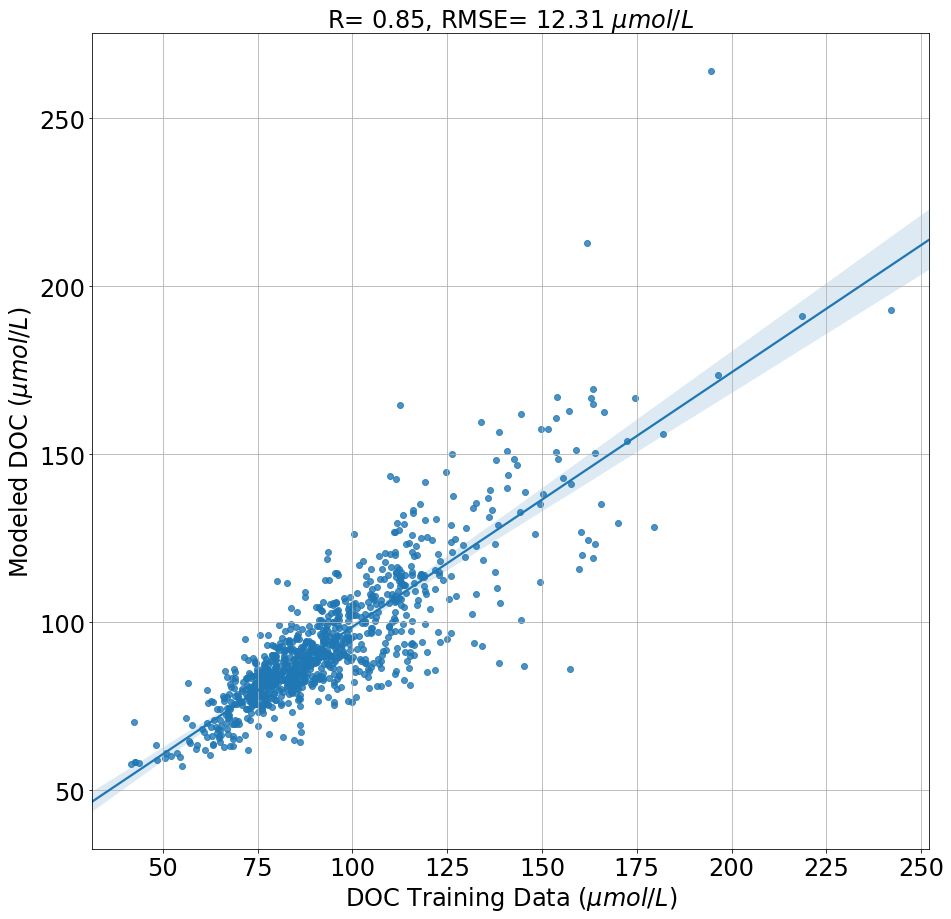

In [88]:
# use the function regplot to make a scatterplot of training vs fit data
fig = plt.figure(figsize=(15,15))
sns.regplot(x=y_train, y=y_pred2)
plt.grid()
plt.xlabel('DOC Training Data ($\mu mol/L$)')
plt.ylabel('Modeled DOC ($\mu mol/L$)')
plt.title(f'R={float(r_value_train): .2f}, RMSE={float(rmse_val_train): .2f} $\mu mol/L$')

In [89]:
# Generated linear fit line for test data
slope, intercept, r_value_test, p_value, std_err = stats.linregress(np.squeeze(y_test).T,y_pred)
liney = slope*y_test+intercept
slope, intercept, r_value_test, p_value, std_err

(0.93758877479625169,
 9.4743752391989773,
 0.8065039610690401,
 1.4821783831935314e-55,
 0.044836062084570728)

Text(0.5,1,'R= 0.81, RMSE= 17.69 $\\mu mol/L$')

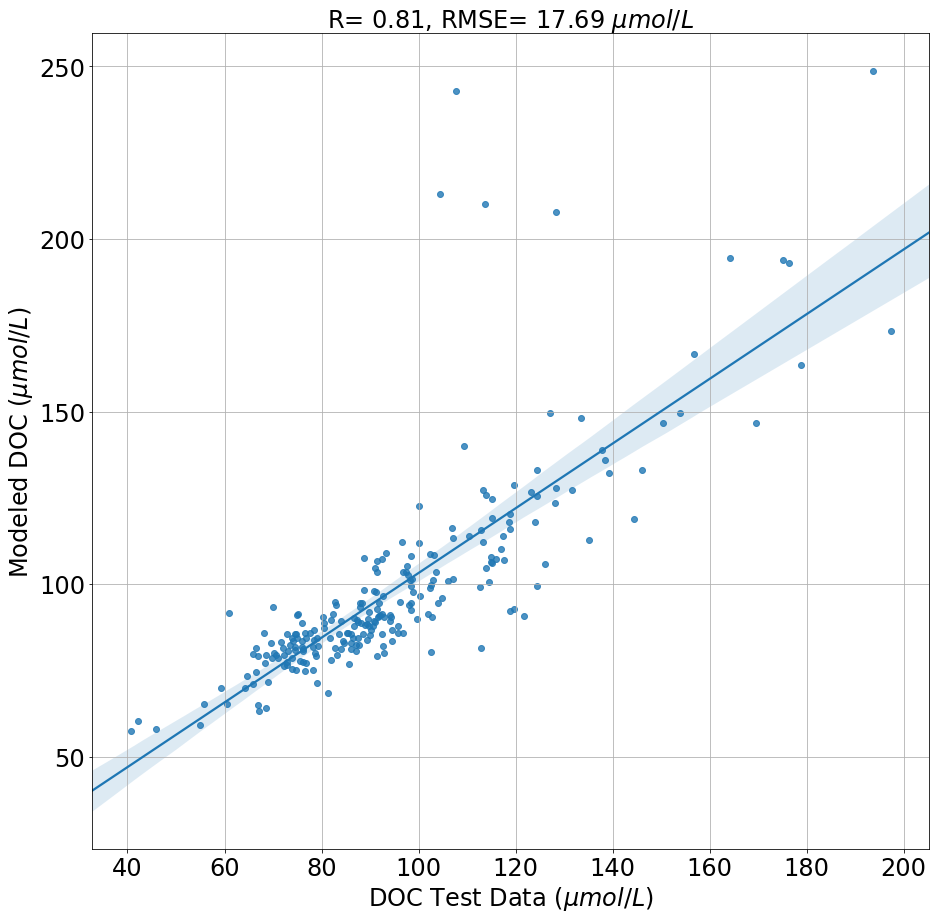

In [90]:
# use the function regplot to make a scatterplot of test vs fit data
fig = plt.figure(figsize=(15,15))
sns.regplot(x=y_test, y=y_pred)
plt.grid()
plt.xlabel('DOC Test Data ($\mu mol/L$)')
plt.ylabel('Modeled DOC ($\mu mol/L$)')
plt.title(f'R={float(r_value_test): .2f}, RMSE={float(rmse_val_test): .2f} $\mu mol/L$')

### Save the model architecture, weights, and optimizer state

In [115]:
# serialize weights to HDF5
doc_keras_model.model.save("doc_keras_model.h5")
print("Saved model to disk")

Saved model to disk


### To load compiled model identical to the one generated above 

In [116]:
docmodel = load_model('doc_keras_model.h5')

In [125]:
# evaluate loaded model on test data
ypred = doc_keras_model.predict(X_test)
score = mean_absolute_error(y_test, ypred)
score

9.8695278904910833

In [126]:
doc_keras_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 14)                56        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
